In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from tensorboardX import SummaryWriter
from time import time
import cv2

Populating the interactive namespace from numpy and matplotlib


/home/xupeng/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from __future__ import print_function, division
import os, sys
import numpy as np
import random
import pickle, h5py, time, argparse, itertools, datetime

import torch
import torch.nn as nn
import torch.utils.data

In [3]:
cd /home/xupeng/projects/membrane

/home/xupeng/projects/membrane


In [4]:
sys.path.append('bin/DeepGlobe-Road-Extraction-Challenge-master/networks/')
sys.path.append('bin/DeepGlobe-Road-Extraction-Challenge-master/')
sys.path.append('bin/')

In [5]:
from augmentation import IntensityAugment, simpleaug_train_produce
from augmentation import apply_elastic_transform, apply_deform

In [6]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable as V
import cv2
import os
import numpy as np
from time import time
from networks.unet import Unet
from networks.dunet import Dunet
from networks.dinknet import LinkNet34, DinkNet34, DinkNet50, DinkNet101, DinkNet34_less_pool
from framework import MyFrame
from loss import dice_bce_loss
from data import ImageFolder,default_loader

In [47]:
import torch.utils.data as data
def default_loader(img,mask):
    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-30, 30),
                                   sat_shift_limit=(-5, 5),
                                   val_shift_limit=(-15, 15))
    
    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0.1, 0.1),
                                       scale_limit=(-0.1, 0.1),
                                       aspect_limit=(-0.1, 0.1),
                                       rotate_limit=(-0, 0))
    img, mask = randomHorizontalFlip(img, mask)
    img, mask = randomVerticleFlip(img, mask)
    img, mask = randomRotate90(img, mask)
    
    mask = np.expand_dims(mask, axis=2)
    img = np.array(img, np.float32).transpose(2,0,1)/255.0 * 3.2 - 1.6
    mask = np.array(mask, np.float32).transpose(2,0,1)/255.0
    mask[mask>=0.5] = 1
    mask[mask<=0.5] = 0
    #mask = abs(mask-1)
    return img, mask
class ImageFolder(data.Dataset):

    def __init__(self, img, mask):
        self.loader = default_loader
        self.img = img
        self.mask = mask

    def __getitem__(self):
        img_, mask_ = self.loader(self.img, self.mask)
        img = torch.Tensor(img_)
        mask = torch.Tensor(mask_)
        return img, mask

    def __len__(self):
        return self.img.shape[0]

In [48]:
SHAPE = (512,512)
dataset = ImageFolder(imgs,masks)

In [49]:
for i in dataset:
    print (i[0].size())
    print (i[1].size())

TypeError: __getitem__() takes exactly 1 argument (2 given)

In [9]:
imgs = np.zeros([4,3,1024,1024])
masks = np.zeros([4,1,1024,1024])

In [9]:
imgs.shape, masks.shape

((1024, 1024, 3), (1024, 1024, 3))

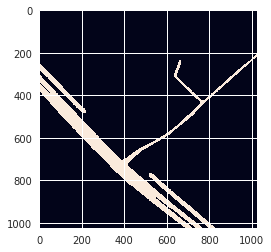

In [10]:
imshow(masks[:,:,0])

## prepare dataloader

In [11]:
with h5py.File('data/train_set/marco/coloredmaskmip0whole.h5') as f:
    masks = f['main'][:10]
with h5py.File('data/train_set/marco/emmip0whole.h5') as f:
    imgs = f['main'][:10]

In [12]:
masks.shape, imgs.shape

((10, 1112, 1734), (10, 1112, 1734))

In [27]:
new_imgs = np.stack((imgs,)*3, 1)
new_masks = np.stack((masks,)*1, 1)

In [35]:
new_imgs.shape,new_masks.shape

((1434, 3, 1112, 1734), (1434, 1, 1112, 1734))

In [13]:
train_input= imgs/255.0
train_label = masks
model_io_size = np.array([512,512])

In [14]:
train_input.shape, train_label.shape

((10, 1112, 1734), (10, 1112, 1734))

In [15]:
train_input = np.stack((train_input,)*1,0)
train_label = np.stack((train_label,)*1,0)

In [16]:
train_input.shape, train_label.shape

((1, 10, 1112, 1734), (1, 10, 1112, 1734))

In [18]:
dataset = SynapseDataset(volume=train_input, label=train_label, vol_input_size=model_io_size, \
                                 vol_label_size=model_io_size, data_aug = True, mode = 'train')

input volume and label shape 1 1 (10, 1112, 1734) (10, 1112, 1734)
inputsize, vol inputsize 1 [array([  10, 1112, 1734])] [512 512]


In [19]:
dataset[0][0].shape,dataset[0][1].shape

shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)


(torch.Size([1, 10, 512, 512]), torch.Size([1, 10, 512, 512]))

In [20]:
opt ='train'
SHUFFLE = (opt=='train')
img_loader =  torch.utils.data.DataLoader(
            dataset, batch_size=2, shuffle=SHUFFLE, collate_fn = collate_fn,
            num_workers=1, pin_memory=True)

In [22]:
count = 0
for data in img_loader:
    if count <5:
        print ('dataseiz',data[0].size())
        count+=1
    else:
        break

shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
dataseiz torch.Size([2, 1, 10, 512, 512])
dataseiz torch.Size([2, 1, 10, 512, 512])
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
dataseiz torch.Size([2, 1, 10, 512, 512])
dataseiz torch.Size([2, 1, 10, 512, 512])
dataseiz torch.Size([2, 1, 10, 512, 512])
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)


In [24]:
count = 0
volumess ,labelss = {},{}
for i, (volume, label) in tqdm(enumerate(img_loader)):
    if count <5:
        print (i, volume.size(), label.size())
        volumess[i] = volume.numpy()
        labelss[i] = label.numpy()
        count+=1
    else:
        break

0it [00:00, ?it/s]

shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)


1it [00:00,  9.56it/s]

shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)


3it [00:00, 11.01it/s]

shape after cropvolume (10, 512, 512)
0 torch.Size([2, 1, 10, 512, 512]) torch.Size([2, 1, 10, 512, 512])
1 torch.Size([2, 1, 10, 512, 512]) torch.Size([2, 1, 10, 512, 512])
2 torch.Size([2, 1, 10, 512, 512]) torch.Size([2, 1, 10, 512, 512])
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)


4it [00:00, 10.21it/s]

shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)
3 torch.Size([2, 1, 10, 512, 512]) torch.Size([2, 1, 10, 512, 512])
4 torch.Size([2, 1, 10, 512, 512]) torch.Size([2, 1, 10, 512, 512])


Exception KeyError: KeyError(<weakref at 0x7fd7b6eff470; to 'tqdm' at 0x7fd7b6eb30d0>,) in <bound method tqdm.__del__ of 4it [00:00,  6.82it/s]> ignored


shape after cropvolume (10, 512, 512)
shape after cropvolume (10, 512, 512)


In [25]:
volumess[0].shape

(2, 1, 10, 512, 512)

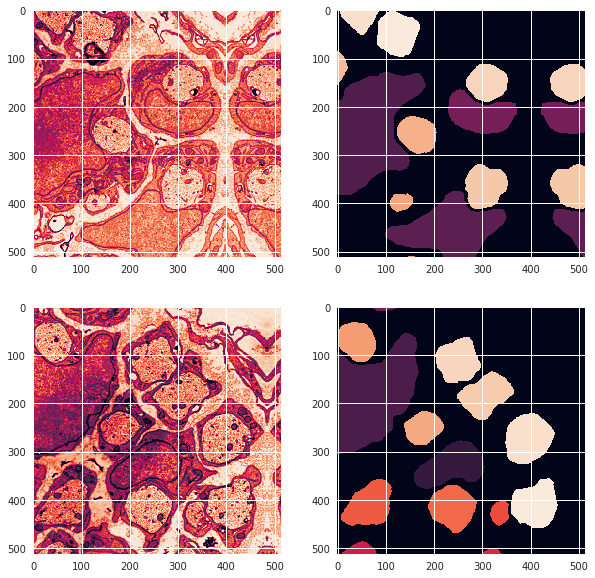

In [30]:
sampleind = 4
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(volumess[0][0,0,sampleind,:,:])
ax[0,1].imshow(labelss[0][0,0,sampleind,:,:])

ax[1,0].imshow(volumess[0][1,0,sampleind,:,:])
ax[1,1].imshow(labelss[0][1,0,sampleind,:,:])

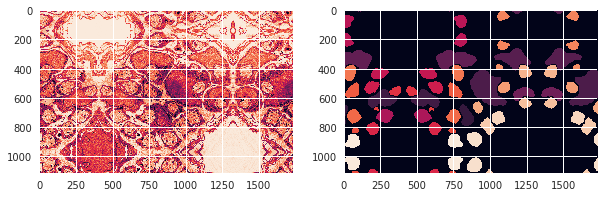

In [33]:
sampleind = 4
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(imgs[sampleind])
ax[1].imshow(masks[sampleind])

# try to use 2D similar to synapsedataset

In [17]:
from __future__ import print_function, division
import os, sys
import numpy as np
import random
import pickle, h5py, time, argparse, itertools, datetime

import torch
import torch.nn as nn
import torch.utils.data



# -- 1.0 dataset -- 
# dataset class for synaptic cleft inputs
class SynapseDataset(torch.utils.data.Dataset):
    # assume for test, no warping [hassle to warp it back..]
    def __init__(self,
                 volume, label=None,
                 vol_input_size = (512,512),
                 vol_label_size = None,
                 sample_stride = (1,1),
                 data_aug = False,
                 mode = 'train'):
        
        self.mode = mode

        # data format
        self.input = volume
        self.label = label
        self.data_aug = data_aug # data augmentation
        print ('input volume and label shape',len(volume),len(label),volume[0].shape, label[0].shape)
        
        # samples, channels,rows, cols
        self.input_size = [np.array(x.shape) for x in self.input] 
        # whole volume size 1435*...*...,vol_input_size: self assign in cremi 4*256*256, but now i need 512*512
        
        print ('inputsize, vol inputsize',len(self.input_size),self.input_size,vol_input_size)
        
        self.vol_input_size = np.array(vol_input_size) # model input size
        self.vol_label_size = np.array(vol_label_size) # model label size
        
        
        
        # compute number of samples for each dataset (multi-volume input)
        self.sample_stride = np.array(sample_stride, dtype=np.float32)
        
        self.sample_size = [ countVolume(self.input_size[x][1:], self.vol_input_size, np.array(self.sample_stride)) \
                            for x in range(len(self.input_size))]
        #total number of possible inputs for each volume
        self.sample_num = np.array([np.prod(x) for x in self.sample_size])
        self.sample_num_a = np.sum(self.sample_num)
        self.sample_num_c = np.cumsum([0] + list(self.sample_num))
        #print(self.sample_num_c)
        assert self.sample_num_c[-1] == self.sample_num_a

        '''
        Image augmentation
        1. self.simple_aug: Simple augmentation, including mirroring and transpose
        2. self.intensity_aug: Intensity augmentation
        '''
        if self.data_aug:
            self.simple_aug = simpleaug_train_produce(model_io_size = self.vol_input_size)
            #self.intensity_aug = IntensityAugment(mode='mix', skip_ratio=0.9, CONTRAST_FACTOR=0.005, BRIGHTNESS_FACTOR=0.005)

        # for test
        self.sample_size_vol = [np.array([np.prod(x[0:2]),x[1]]) for x in self.sample_size]

    def __getitem__(self, index):

        if self.mode == 'train':
            # 1. get volume size
            vol_size = self.vol_input_size
            # if self.data_aug is not None: # augmentation
            #     self.data_aug.getParam() # get augmentation parameter
            #     vol_size = self.data_aug.aug_warp[0]
            # train: random sample based on vol_size
            # test: sample based on index    
            
            # reject no-synapse samples with a probability of p 

            
            seed = np.random.RandomState(index)
            while True:
                pos = self.getPosSeed(vol_size, seed)
                out_label = cropVolume(self.label[pos[0]], vol_size, pos[1:])
                if np.sum(out_label) > 100:
                    break
                else:
                    if random.random() > 0.75:
                        break  

            # 2. get input volume
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            print ('shape after cropvolume', out_input.shape)
            # out_label = cropVolume(self.label[pos[0]], vol_size, pos[1:])

            # 3. augmentation
            if self.data_aug: # augmentation
                #if random.random() > 0.5:
                #    out_input, out_label = apply_elastic_transform(out_input, out_label)    
                out_input, out_label = self.simple_aug(out_input, out_label)
                #out_input = self.intensity_aug.augment(out_input)
                #out_input = apply_deform(out_input)
            
            # 4. class weight
            # add weight to classes to handle data imbalance
            # match input tensor shape
            out_input = torch.from_numpy(out_input.copy())
            out_label = torch.from_numpy(out_label.copy())
            #weight_factor = out_label.float().sum() / torch.prod(torch.tensor(out_label.size()).float())
            #weight_factor = torch.clamp(weight_factor, min=1e-3)
            # the fraction of synaptic cleft pixels, can be 0
            #weight = out_label*(1-weight_factor)/weight_factor + (1-out_label)

            # include the channel dimension
            out_input = out_input.unsqueeze(0)
            out_label = out_label.unsqueeze(0)
            #weight = weight.unsqueeze(0)

            return out_input, out_label#, weight, weight_factor

        elif self.mode == 'test':
            # 1. get volume size
            vol_size = self.vol_input_size  
            # test mode
            pos = self.getPosTest(index)
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            out_input = torch.Tensor(out_input)
            out_input = out_input.unsqueeze(0)

            return pos, out_input  

    def __len__(self): # number of possible position
        return self.sample_num_a
    
    def getPosDataset(self, index):
        return np.argmax(index<self.sample_num_c)-1 # which dataset

    def getPos(self, vol_size, index):
        pos = [0,0,0,0]
        # support random sampling using the same 'index'
        seed = np.random.RandomState(index)
        did = self.getPosDataset(seed.randint(self.sample_num_a))
        pos[0] = did
        tmp_size = countVolume(self.input_size[did][1:], vol_size, np.array(self.sample_stride))
        pos[1:] = [np.random.randint(tmp_size[x]) for x in range(len(tmp_size))]
        return pos

    def index2zyx(self, index): # for test
        # int division = int(floor(.))
        pos = [0,0,0,0]
        did = self.getPosDataset(index)
        pos[0] = did
        index2 = index - self.sample_num_c[did]
        pos[1:] = self.getPosLocation(index2, self.sample_size_vol[did])
        return pos 

    def getPosLocation(self, index, sz):
        # sz: [y*x, x]
        pos = [0,0,0]
        pos[0] = np.floor(index/sz[0])
        pz_r = index % sz[0]
        pos[1] = np.floor(pz_r/sz[1])
        pos[2] = pz_r % sz[1]
        return pos 

    def getPosTest(self, index):
        pos = self.index2zyx(index)
        for i in range(1,4):
            if pos[i] != self.sample_size[pos[0]][i-1]-1:
                pos[i] = int(pos[i] * self.sample_stride[i-1])
            else:
                pos[i] = int(self.input_size[pos[0]][i-1]-self.vol_input_size[i-1])
        return pos

    def getPosSeed(self, vol_size, seed):
        pos = [0,0,0,0]
        did = self.getPosDataset(seed.randint(self.sample_num_a))
        pos[0] = did
        tmp_size = countVolume(self.input_size[did][1:], vol_size, np.array(self.sample_stride))
        pos[1:] = [np.random.randint(tmp_size[x]) for x in range(len(tmp_size))]
        return pos  
     

# -- 2. misc --
# for dataloader

def collate_fn(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    out_input, out_label = zip(*batch)
    out_input = torch.stack(out_input, 0)
    out_label = torch.stack(out_label, 0)
    #weights = torch.stack(weights, 0)

    #weight_factor = np.stack(weight_factor, 0)

    return out_input, out_label

def collate_fn_test(batch):
    pos, out_input = zip(*batch)
    test_sample = torch.stack(out_input, 0)

    return pos, test_sample

def collate_fn_refine(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    out_input, out_label= zip(*batch)
    out_input = torch.stack(out_input, 0)
    out_label = torch.stack(out_label, 0)
    #weights = torch.stack(weights, 0)
    #roi = torch.stack(roi, 0)

    #weight_factor = np.stack(weight_factor, 0)

    return out_input, out_label#, weights, weight_factor, roi   

def collate_fn_refine_test(batch):
    pos, out_input = zip(*batch)
    test_sample = torch.stack(out_input, 0)   

    return pos, test_sample 
def augmentsimple(data, rule):
    assert np.size(rule) == 4 and data.ndim == 3
    # z reflection.
    if rule[0]:
        data = data[::-1, :, :]
    # x reflection.
    if rule[1]:
        data = data[:, :, ::-1]
    # y reflection.
    if rule[2]:
        data = data[:, ::-1, :]
    # Transpose in xy.
    if rule[3]:
        data = data.transpose(0, 2, 1)
    return data


def produce_simple_train_sample(imgs, rule):
    '''
    imgs: 512*512 -> 8*512*512
    '''
    assert imgs.ndim == 3
    return augmentsimple(imgs, rule)
class simpleaug_train_produce():
    def __init__(self, model_io_size=[512, 512]):
        self.model_io_size = model_io_size

    def __call__(self, imgs, mask):
        #print (self.rule)
        rule = np.random.randint(2, size=4)
        imgs_aug = produce_simple_train_sample(imgs, rule)
        mask_aug = produce_simple_train_sample(mask, rule)
        return imgs_aug, mask_aug

    def multi_mask(self, inputs):
        #print (self.rule)
        rule = np.random.randint(2, size=4)
        for idx in range(len(inputs)):
            inputs[idx] = produce_simple_train_sample(inputs[idx], rule)
        return inputs 